In [1]:
%reload_ext autoreload

%autoreload 2

In [2]:
from Libraries_functions import *
from tqdm import tqdm
import glob
import ipywidgets as widgets
from IPython.display import display

In [3]:
preprocess_files()

  6%|▋         | 13/200 [00:00<00:01, 118.54it/s]

Processed file ../../Datasets/Test/mixed_sound/mixed_sound10066.wav


100%|██████████| 200/200 [00:01<00:00, 111.74it/s]


## Cargamos el modelo y los datos

In [4]:
# model= VAE.load(PATH_TO_MODEL)

min_max_values= load_min_max(MIN_MAX_VALUES)
spectrograms, file_path = load_form_direc(SPECTROGRAMS_SAVE_DIR)
sampled_specs, sampled_min_max_values, file_path = select_spectrograms(spectrograms, file_path, min_max_values, num_spectrograms=200)
voice_paths= search_voices(file_path)

50
['../../Datasets/Data/tests/mixed_sound13324.wav.npy', '../../Datasets/Data/tests/mixed_sound2015.wav.npy', '../../Datasets/Data/tests/mixed_sound5093.wav.npy', '../../Datasets/Data/tests/mixed_sound5884.wav.npy', '../../Datasets/Data/tests/mixed_sound8998.wav.npy', '../../Datasets/Data/tests/mixed_sound13025.wav.npy', '../../Datasets/Data/tests/mixed_sound1690.wav.npy', '../../Datasets/Data/tests/mixed_sound10564.wav.npy', '../../Datasets/Data/tests/mixed_sound9531.wav.npy', '../../Datasets/Data/tests/mixed_sound9169.wav.npy', '../../Datasets/Data/tests/mixed_sound2239.wav.npy', '../../Datasets/Data/tests/mixed_sound10753.wav.npy', '../../Datasets/Data/tests/mixed_sound5478.wav.npy', '../../Datasets/Data/tests/mixed_sound10569.wav.npy', '../../Datasets/Data/tests/mixed_sound1912.wav.npy', '../../Datasets/Data/tests/mixed_sound4751.wav.npy', '../../Datasets/Data/tests/mixed_sound6933.wav.npy', '../../Datasets/Data/tests/mixed_sound6567.wav.npy', '../../Datasets/Data/tests/mixed_soun

## load from vae_auto_propio

In [5]:
model_name="VAE_weights_build_VAE_Skipp_complejo_loss_0.0_alpha_0.3_dim_2048"
alpha=0.3
latent=2048
learning_rate=0.0001

vae, _=VAE.load_model_complete(sampled_specs,alpha,latent, learning_rate)
# vae=VAE.load_model(sampled_specs,alpha,latent, learning_rate)

vae= VAE.load_model_weights(vae, save_folder= PATH_TO_MODEL, name=f"{model_name}.h5")

signals=vae.predict(sampled_specs)

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                           

c:\Users\javca\anaconda3\envs\Ceiec\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


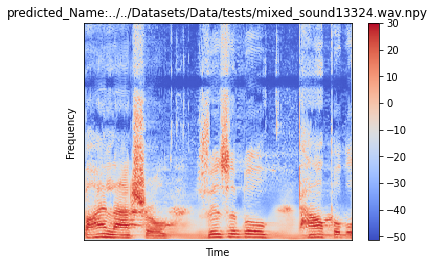

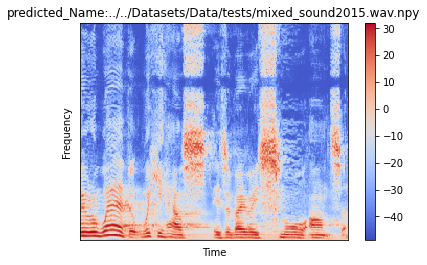

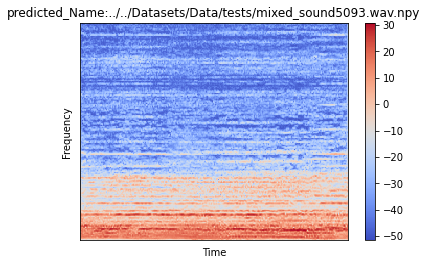

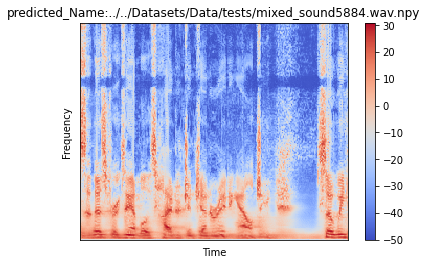

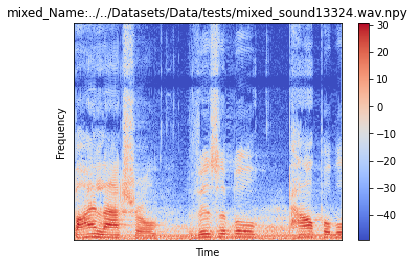

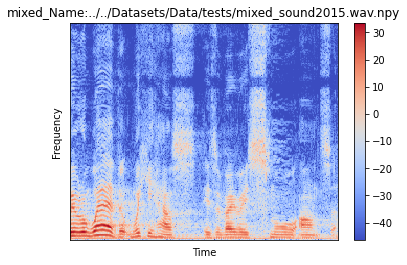

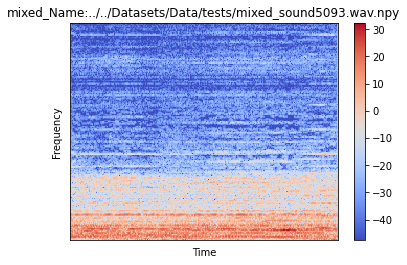

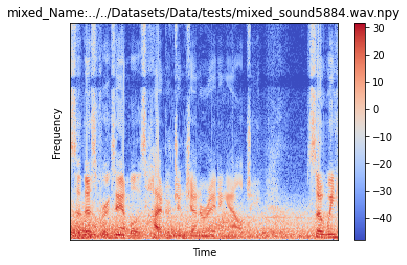

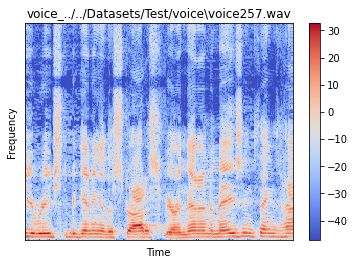

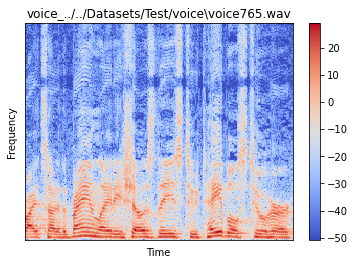

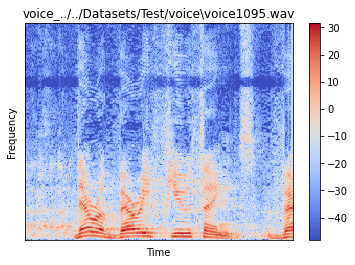

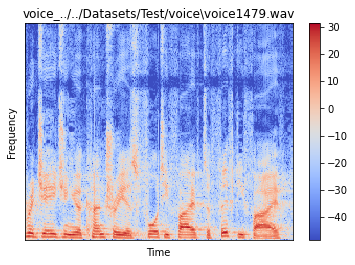

In [6]:
new_signals, predicted_path = convert_spectrograms_to_audio(
    signals, sampled_min_max_values,False,file_path )

original_signals, mixed_path = convert_spectrograms_to_audio(
    sampled_specs, sampled_min_max_values,True, file_path)

real_signals, real_path=spectrograms_of_voice(voice_paths)

In [7]:
style = {'description_width': 'initial'}

generating= widgets.Dropdown(
    options=[('Metrics', 0), ('Generate audios', 1)],
    value=1,
    description='Select_metrics or Generate audios',
    style=style,
    layout={'width': 'max-content'}
)

display(generating)

Dropdown(description='Select_metrics or Generate audios', index=1, layout=Layout(width='max-content'), options…

In [17]:
if generating.value==1:
    for i in range(len(predicted_path)):
        predicted_path[i]=predicted_path[i].split("d")[-1].split(".")[0]
    for i in range(len(mixed_path)):
        mixed_path[i]=mixed_path[i].split("d")[-1].split(".")[0]
    for i in range(len(real_path)):
        real_path[i]=real_path[i].split("e")[-1].split(".")[0]
    save_signals(new_signals, SAVE_DIR_GENERATED, predicted_path, "predicted_")
    save_signals(original_signals, SAVE_DIR_ORIGINAL, mixed_path, "mixed_")
    save_signals(real_signals, SAVE_DIR_REAL, real_path, "real_")


########################################################################################################################
else:
    #convert list to numpy
    real_signals=np.array(real_signals)
    new_signals=np.array(new_signals)
    original_signals=np.array(original_signals)
########################################################################################################################
# MSE Metrics
    aircrafts=[]
    lluvia=[]
    trafico=[]
    viento=[]
    #TODO: comprobar que los intervlos de numeros esten bien puestos.
    for i in tqdm(range(new_signals.shape[0])):
        if(i<=new_signals.shape[0]/4-1):
            aircrafts.append(mean_squared_error(new_signals[i], original_signals[i],squared=True))
        elif(i>=new_signals.shape[0]/4 and i<=((new_signals.shape[0]/4)*2)-1):
            lluvia.append(mean_squared_error(new_signals[i], original_signals[i],squared=True))
        elif(i>=((new_signals.shape[0]/4)*2) and i<((new_signals.shape[0]/4)*3)-1):
            trafico.append(mean_squared_error(new_signals[i], original_signals[i],squared=True))
        else:
            viento.append(mean_squared_error(new_signals[i], original_signals[i],squared=True))

    
    df_MSE=pd.DataFrame()
    df_MSE.insert(0,"aircrafts_mean",[mean(aircrafts)])
    df_MSE.insert(1,"aircrafts_desviacion",[desviacion(aircrafts)])

    df_MSE.insert(2,"lluvia_mean",[mean(lluvia)])
    df_MSE.insert(3,"lluvia_desviacion",[desviacion(lluvia)])

    df_MSE.insert(4,"trafico_mean",[mean(trafico)])
    df_MSE.insert(5,"trafico_desviacion",[desviacion(trafico)])

    df_MSE.insert(6,"viento_mean",[mean(viento)])
    df_MSE.insert(7,"viento_desviacion",[desviacion(viento)])

    exception_pesq=0
    aircrafts=[]
    lluvia=[]
    trafico=[]
    viento=[]
    for i in tqdm(range(new_signals.shape[0])):
        #if(i!=139 and i!=157):
        try:
            if(i<=new_signals.shape[0]/4-1):
                aircrafts.append(pesq(16000, original_signals[i], new_signals[i],'wb'))
            elif(i>=new_signals.shape[0]/4 and i<=((new_signals.shape[0]/4)*2)-1):
                lluvia.append(pesq(16000, original_signals[i], new_signals[i],'wb'))
            elif(i>=((new_signals.shape[0]/4)*2) and i<((new_signals.shape[0]/4)*3)-1):
                trafico.append(pesq(16000, original_signals[i],new_signals[i],'wb'))
            else:
                viento.append(pesq(16000, original_signals[i], new_signals[i],'wb'))
        except:
            exception_pesq+=1

    df_pesq=pd.DataFrame()
    df_pesq.insert(0,"aircrafts_mean",[mean(aircrafts)])
    df_pesq.insert(1,"aircrafts_desviacion",[desviacion(aircrafts)])

    df_pesq.insert(2,"lluvia_mean",[mean(lluvia)])
    df_pesq.insert(3,"lluvia_desviacion",[desviacion(lluvia)])

    df_pesq.insert(4,"trafico_mean",[mean(trafico)])
    df_pesq.insert(5,"trafico_desviacion",[desviacion(trafico)])

    df_pesq.insert(6,"viento_mean",[mean(viento)])
    df_pesq.insert(7,"viento_desviacion",[desviacion(viento)])


    exception_snr=0
    aircrafts=[]
    lluvia=[]
    trafico=[]
    viento=[]
    for i in tqdm(range(new_signals.shape[0])):
        try:
            if(i<=new_signals.shape[0]/4-1):
                # aircrafts[0].append(signaltonoise(df_data.data[i]))
                # aircrafts[1].append(signaltonoise(df_data.noise_original[i]))
                aircrafts.append(SNRsystem(new_signals[i], original_signals[i]))
            elif(i>=new_signals.shape[0]/4 and i<=((new_signals.shape[0]/4)*2)-1):
                # lluvia[0].append(signaltonoise(df_data.data[i]))
                # lluvia[1].append(signaltonoise(df_data.noise_original[i]))
                lluvia.append(SNRsystem(new_signals[i], original_signals[i]))
            elif(i>=((new_signals.shape[0]/4)*2) and i<((new_signals.shape[0]/4)*3)-1):
                # trafico[0].append(signaltonoise(df_data.data[i]))
                # trafico[1].append(signaltonoise(df_data.noise_original[i]))
                trafico.append(SNRsystem(new_signals[i], original_signals[i]))
            else:
                # viento[0].append(signaltonoise(df_data.data[i]))
                # viento[1].append(signaltonoise(df_data.noise_original[i]))
                viento.append(SNRsystem(new_signals[i], original_signals[i]))
        except:
            exception_snr+=1
    
    df_snr=pd.DataFrame()
    df_snr.insert(0,"aircrafts_mean",[mean(aircrafts)])
    df_snr.insert(1,"aircrafts_desviacion",[desviacion(aircrafts)])

    df_snr.insert(2,"lluvia_mean",[mean(lluvia)])
    df_snr.insert(3,"lluvia_desviacion",[desviacion(lluvia)])

    df_snr.insert(4,"trafico_mean",[mean(trafico)])
    df_snr.insert(5,"trafico_desviacion",[desviacion(trafico)])

    df_snr.insert(6,"viento_mean",[mean(viento)])
    df_snr.insert(7,"viento_desviacion",[desviacion(viento)])

100%|██████████| 200/200 [00:03<00:00, 62.38it/s]


In [18]:
df_MSE

,aircrafts_mean,aircrafts_desviacion,lluvia_mean,lluvia_desviacion,trafico_mean,trafico_desviacion,viento_mean,viento_desviacion
0,0.017342,0.019072,0.030215,0.027945,0.018776,0.011085,0.026243,0.028274


In [19]:
print(exception_pesq)
df_pesq

10


,aircrafts_mean,aircrafts_desviacion,lluvia_mean,lluvia_desviacion,trafico_mean,trafico_desviacion,viento_mean,viento_desviacion
0,1.538281,0.434033,1.261018,0.308795,1.299534,0.293104,1.567574,0.429188


## Measuring SNR

### Calculate SNR on 1 signal
Sometimes, the question arises how to get the noise and the Signal separately.
One method is to measure the constant noise power a device *produces without an input*, let's call that $P_n$ and measure the power of the output of a device *with* an input, lets call that $P_s$. By subtraction of the powers, we can estimate the power of the signal alone and therefore the ratio between signal and noise power (assuming noise power stays constant).     

$$ SNR_{db}=10 \cdot \log_{10} \frac {P_s - P_n}{P_n}$$

- $P(s)$ is a function that computes the power of a signal.
- $P_s$ in this case is the power of the signal + the noise, typically the output of the system we want to measure **with** an input signal.
- $P_n$ in this case is the power of just the noise, typically the output of the system we want to measure **without** an input signal.

### Difference between 2 signals
Another method is to try to make the system as clean as possible (eg bypass or similar *at unity gain!*), measure input signal power $P_i$ and output signal power $P_o$ and just assume that the difference between them is the level of noise being added:
$$ P_n = P_o - P_i $$
The rest of the comutation stays the same as Method 1.

## Abstract
When we make the snr of 2 signals, we are measuring the quantity of db that is different in the the original sound vs the noisy sound. This means that we obtain the theorical magnitud of noise.


In [20]:
print(exception_snr)
df_snr ## tener 1db o db negativos en la media, significa que elimina mucho ruido.

24


,aircrafts_mean,aircrafts_desviacion,lluvia_mean,lluvia_desviacion,trafico_mean,trafico_desviacion,viento_mean,viento_desviacion
0,1.369745,4.040705,-1.256219,4.003129,0.469263,1.973453,-0.155652,3.502002
